<a href="https://colab.research.google.com/github/MeldaChen/Group-4/blob/main/%E4%B8%BB%E7%A8%8B%E5%BC%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import cv2
import numpy as np
import IPython.display as dp
from google.colab.patches import cv2_imshow
from PIL import ImageFont, ImageDraw, Image


m1 = cv2.imread('A036.jpg', 1)

copy = m1.copy()

m1_g = cv2.cvtColor(m1, cv2.COLOR_BGR2GRAY) # 手寫字轉灰階

ret, m1_new = cv2.threshold(m1_g, 127, 255, cv2.THRESH_BINARY) # 手寫字轉黑底白字 

erode = cv2.erode(copy, np.ones((30, 30))) #抓字

gray = cv2.cvtColor(copy, cv2.COLOR_BGR2GRAY) #轉灰階

blur = cv2.GaussianBlur(gray,(5,5),0)   #模糊化


canny = cv2.Canny(blur, 70, 210)

th, canny = cv2.threshold(canny, 10, 255, cv2.THRESH_BINARY)

morph = cv2.morphologyEx(canny, cv2.MORPH_GRADIENT, np.ones((10, 10))) 
p, t = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if len(p)== 1:
    x, y, w, h = cv2.boundingRect(p[0]) 
    cv2.rectangle(m1_new, (x,y), (x+w, y+h), (255, 255, 255), 2) #框線改白色
    cv2.imwrite("capture.png", m1_new[y : y + h, x : x + w]) #將框起來的地方存成capture.png

else:
  print("請靠近文字再拍攝一次")


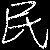

大


In [29]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

y_dict = {0:"者",1:"我",2:"國",3:"來",4:"面",5:"過",6:"為",7:"大",8:"成",9:"民"}
m = cv2.ml.KNearest_load('tch_knn.xml')   # 載入模型
m1 = cv2.imread("capture.png", 0)
ret, m1 = cv2.threshold(m1, 127, 255, cv2.THRESH_BINARY_INV)
m1 = cv2.resize(m1,(50, 50))
cv2_imshow(m1)

m1 = m1.astype(np.float32)    # 轉換格式
m1 = m1.reshape(-1)          # 打散成一維陣列資料，轉換成辨識使用的格式
m1 = m1.reshape(1,-1)
m1 = m1/255

img_pre = m.predict(m1)          # 進行辨識

text = int(img_pre[1][0][0])        # 取得辨識結果

print(y_dict[text])

In [30]:
import cv2
from google.colab.patches import cv2_imshow
from PIL import ImageFont, ImageDraw, Image

capture_img = cv2.imread('capture.png', 1)

resize_capture = cv2.resize(capture_img, (50, 50), interpolation=cv2.INTER_AREA)
cv2.imwrite("resize_capture.png", resize_capture) #存成 50*50 的手寫字

compare_word = np.full((50, 50, 3), (255, 255, 255), np.uint8) 
compare_word = Image.fromarray(compare_word)
ImageDraw.Draw(compare_word).text((0,0),
            (y_dict[text]),
            (0, 0, 0),
            ImageFont.truetype("ThePeakFontBeta_V0_101.ttf", 50)  #要上傳字體
)
compare_word = np.array(compare_word)
cv2.imwrite("compare.png", compare_word) # 生成的字存成 compare.png，要再取一次輪廓

compare_img = cv2.imread('compare.png', 1) 

copy = compare_img.copy()

# erode = cv2.erode(copy, np.ones((30, 30)))  

# blur = cv2.GaussianBlur(erode,(5,5),0) 

canny = cv2.Canny(copy, 70, 210)

th, canny = cv2.threshold(canny, 10, 255, cv2.THRESH_BINARY)

morph = cv2.morphologyEx(canny, cv2.MORPH_GRADIENT, np.ones((10, 10))) 
p, t = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
x, y, w, h = cv2.boundingRect(p[0]) 
cv2.rectangle(compare_img, (x,y), (x+w, y+h), (255, 255, 255), 2)  #框線改白色
cv2.imwrite("compare2.png", compare_img[y : y + h, x : x + w]) #要再resize

compare2_img = cv2.imread('compare2.png', 1)

resize_compare = cv2.resize(compare2_img, (50, 50), interpolation=cv2.INTER_AREA)
cv2.imwrite("resize_compare.png", resize_compare) #存成 50*50 的比對字 



True

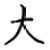

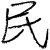

你的分數是 60 分


In [31]:
import cv2
import numpy as np
import IPython.display as dp
from google.colab.patches import cv2_imshow
from PIL import ImageFont, ImageDraw, Image
import time
from matplotlib import pyplot as plt 

 
# 最簡單的以灰度直方圖作為相似比較的實現 
def classify_gray_hist(image1,image2,size = (256,256)): 
 # 先計算直方圖 
 # 幾個引數必須用方括號括起來 
 # 這裡直接用灰度圖計算直方圖，所以是使用第一個通道， 
 # 也可以進行通道分離後，得到多個通道的直方圖 
 # bins 取為16 
 image1 = cv2.resize(image1,size) 
 image2 = cv2.resize(image2,size) 
 hist1 = cv2.calcHist([image1],[0],None,[256],[0.0,255.0]) 
 hist2 = cv2.calcHist([image2],[0],None,[256],[0.0,255.0]) 

 # 計算直方圖的重合度 
 degree = 0 
 for i in range(len(hist1)): 
  if hist1[i] != hist2[i]: 
   degree = degree + (1 - abs(hist1[i]-hist2[i])/max(hist1[i],hist2[i])) 
  else: 
   degree = degree + 1 
 degree = degree/len(hist1) 
 return degree 
 
# 計算單通道的直方圖的相似值 
def calculate(image1,image2): 
 hist1 = cv2.calcHist([image1],[0],None,[256],[0.0,255.0]) 
 hist2 = cv2.calcHist([image2],[0],None,[256],[0.0,255.0]) 
  # 計算直方圖的重合度 
 degree = 0 
 for i in range(len(hist1)): 
  if hist1[i] != hist2[i]: 
   degree = degree + (1 - abs(hist1[i]-hist2[i])/max(hist1[i],hist2[i])) 
  else: 
   degree = degree + 1 
 degree = degree/len(hist1) 
 return degree 
 
# 通過得到每個通道的直方圖來計算相似度 
def classify_hist_with_split(image1,image2,size = (256,256)): 
 # 將影象resize後，分離為三個通道，再計算每個通道的相似值 
 image1 = cv2.resize(image1,size) 
 image2 = cv2.resize(image2,size) 
 sub_image1 = cv2.split(image1) 
 sub_image2 = cv2.split(image2) 
 sub_data = 0 
 for im1,im2 in zip(sub_image1,sub_image2): 
  sub_data += calculate(im1,im2) 
 sub_data = sub_data/3 
 return sub_data 
 
 
if __name__ == '__main__': 
 img1 = cv2.imread('resize_compare.png') 
 cv2_imshow(img1) 
 img2 = cv2.imread('resize_capture.png') 
 cv2_imshow(img2) 
 degree1 = classify_gray_hist(img1,img2) 

 print("你的分數是", int(degree1*100), "分") 
  
 